(268, 293)
(127, 241)
(247, 93)
(639, 228)
124 642 90 296
200
Handedness:  [classification {
  index: 1
  score: 1.0
  label: "Right"
}
]
121.53177261352539
121.53177261352539
148.9275097846985
148.9275097846985
Handedness:  [classification {
  index: 0
  score: 0.999966561794281
  label: "Left"
}
]
four
[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]
i hand
1


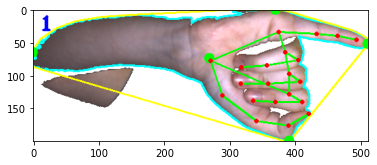

In [24]:
#This uses Reid's code as a base, I made the functions for detecting G, H, and I
import numpy as np
from rdp import rdp
from PIL import Image
import cv2 as cv
import sys
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import imutils
from math import radians, cos, sin, asin, sqrt
import math

def main():

    #img = cv.imread('Documents/hand_6.png')
    img = cv.imread('i hand.png')
    
    #z = 'Documents\SoH\SOH\Spring2021\hand 12.txt'
    #z = 'Documents\GitHub\SoH\Spring2021\Z data\hand 4.txt'
    z = 'i hand.txt'
    #z = 'Documents\SoH\SOH\Spring2021/Z data/hand 11.txt'
    #z = 'Documents\SoH\SOH\Spring2021/m hand.txt'
    z = np.loadtxt(z)
    
    #noise reduction
    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    #lower = np.array([0, 20, 40], dtype="uint8")
    lower = np.array([0, 10, 20], dtype="uint8")
    upper = np.array([255, 255, 255], dtype="uint8")
    skinRegionHSV = cv.inRange(hsvim, lower, upper)
    blurred = cv.blur(skinRegionHSV, (2, 2))
    ret, thresh = cv.threshold(blurred, 0, 255, cv.THRESH_BINARY)
    cv.imwrite("thresh.jpg", thresh)
    #cv.imwrite("thresh.jpg", img)
    
    #contours
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours = max(contours, key=lambda x: cv.contourArea(x))
    cv.drawContours(img, [contours], -1, (255, 255, 0), 2)
    cv.imwrite("contours.jpg", img)
    
    hull = cv.convexHull(contours)
    cv.drawContours(img, [hull], -1, (0, 255, 255), 2)
    cv.imwrite("hull.jpg", img)

    hull = cv.convexHull(contours, returnPoints=False)
    defects = cv.convexityDefects(contours, hull)
    
    #Get Extreme Points
    cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv.contourArea)
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    cv.circle(img, extRight, 8, (0, 255, 0), -1)
    cv.circle(img, extLeft, 8, (0, 255, 0), -1)
    cv.circle(img, extBot, 8, (0, 255, 0), -1)
    cv.circle(img, extTop, 8, (0, 255, 0), -1)
    
    #Get center point
    M = cv.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    cv.circle(img, (cX, cY), 8, (0, 255, 0), -1)
    
    #Top
    x = 640
    while(x > 0):
        y = 0
        while(y < extTop[1] - 10):
            #print(x)
            cv.circle(img, (x, y), 5, (0, 255, 0), -1)
            y = y + 1
        x = x - 1
    
    #Bottom
    x = 0
    while(x < 640):
        y = 480
        while(y > extBot[1] + 10):
            #print(x)
            cv.circle(img, (x, y), 5, (0, 255, 0), -1)
            y = y - 1
        x = x + 1
    #Left
    y = 0
    while(y < 480):
        x = 0
        while(x < extLeft[0] - 10):
            cv.circle(img, (x, y), 5, (0, 255, 0), -1)
            x = x + 1
        y = y + 1
    
    #Right
    y = 0
    while(y < 480):
        x = 640
        while(x > extRight[0] + 10):
            cv.circle(img, (x, y), 5, (0, 255, 0), -1)
            x = x - 1
        y = y + 1
    
    # draw the center of the shape on the image
    #cv.circle(img, (cX, cY), 7, (0, 0, 255), -1)
    cv.imwrite("final_result.jpg", img)
    imgplot = plt.imshow(img)
    print(extBot)
    print(extLeft)
    print(extTop)
    print(extRight)
    
    #img = img.crop((10, 300, 100, 100))
    return img, z, extBot[1], extTop[1], extLeft[0], extRight[0]
    
if __name__ ==  '__main__':
    img, z, y2, y1, x1, x2 = main()
    
print(x1 - 3, x2 + 3, y1 - 3, y2 + 3)
#image = img[120:550, 105:320]
img = img[y1:y2, x1:x2]
z = z[y1:y2, x1:x2]

print(img.shape[0])

#cv.imshow("image", image)
#cv.waitKey(0)
#cv.destroyAllWindows()

#This program should reposition any entered picture to face right, thumb down. It also calculates y positioning (remember, negative axis) and has some new definitions
# There may be some extra/commented code I forgot to delete
# Didn't test all images, probably won't work as well for less accurate joints
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.image as mpimg

#img = cv2.imread('Pictures/hand_2.png')
#img = cv2.imread('Documents/m hand.png')
#rotated     = colorImage.rotate(45)

#imgplot = plt.imshow(img)

#z = 'Documents\SoH\SOH\Spring2021/m hand.txt'
#z = 'Documents/m hand.txt'
#z = np.loadtxt(z)
#print("fdsa", z[200][200])
#image = z.astype(np.float64)
#print(z)
#def createimage(file1,file2,file3):
##    z = np.loadtxt(file3)
#    print("x3 ndim: ", x)
#    print("fdsa", x[200][200])
    
#    length_x = len(x[0])
#    length_y = len(x[::1])
#    image = xyz.reshape(length_y,length_x,3)
#    return image

#image = createimage(x,y,z)
#image = image.astype(np.float64)
#max_img = np.amax(image)
#img_data = image/max_img
#img_data = 255*img_data;

#cv2.imshow("Image",img_data[:,:,0])
#cv2.waitKey(0)
#cv2.destroyAllWindows()

#hsvim = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#lower = np.array([300, 300, 300], dtype="uint8")
#upper = np.array([200, 200, 200], dtype="uint8")
#skinRegionHSV = cv2.inRange(hsvim, lower, upper)
#blurred = cv2.blur(skinRegionHSV, (2, 2))
#ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY)
#img = thresh

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if(img[i][j][0] == 0 and img[i][j][1] == 0 and img[i][j][2] == 0):
            img[i][j][0] = 255
            img[i][j][1] = 255
            img[i][j][2] = 255

imgplot = plt.imshow(img)

mp_hands = mp.solutions.hands

mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=True,
                      max_num_hands=1,
                      min_detection_confidence=0.1)

image = cv2.flip(img,1)
z = cv2.flip(z, 1)

image_hight, image_width, _ = image.shape

results = hands.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

print('Handedness: ', results.multi_handedness)

annoted_image = image.copy()
for hand_landmarks in results.multi_hand_landmarks:
    mp_drawing.draw_landmarks(annoted_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
#imageshow = plt.imshow(cv2.cvtColor(annoted_image,cv2.COLOR_BGR2RGB))
#cv2.imshow("Image",cv2.flip(annoted_image,1))
#cv2.waitKey(0)
#cv2.destroyAllWindows()

p0 = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x * image_width
p1 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].x * image_width
p2 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].x * image_width
p3 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].x * image_width
p4 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x * image_width
p5 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].x * image_width
p6 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].x * image_width
p7 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].x * image_width
p8 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width
p9 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].x * image_width
p10 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].x * image_width
p11 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_DIP].x * image_width
p12 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].x * image_width
p13 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP].x * image_width
p14 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].x * image_width
p15 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_DIP].x * image_width
p16 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].x * image_width
p17 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].x * image_width
p18 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].x * image_width
p19 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_DIP].x * image_width
p20 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].x * image_width

q0 = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y * image_hight
q1 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].y * image_hight
q2 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].y * image_hight
q3 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].y * image_hight
q4 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y * image_hight
q5 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].y * image_hight
q6 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].y * image_hight
q7 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].y * image_hight
q8 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_hight
q9 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].y * image_hight
q10 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].y * image_hight
q11 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_DIP].y * image_hight
q12 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y * image_hight
q13 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP].y * image_hight
q14 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].y * image_hight
q15 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_DIP].y * image_hight
q16 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].y * image_hight
q17 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].y * image_hight
q18 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].y * image_hight
q19 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_DIP].y * image_hight
q20 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].y * image_hight
    
if ((p0 > p12) and (p0 > p20) and (p0 > p4) and (p0 > p8) and (p0 > p16)):
    image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
    z = cv2.rotate(z, cv2.cv2.ROTATE_90_CLOCKWISE)
    image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
    z = cv2.rotate(z, cv2.cv2.ROTATE_90_CLOCKWISE)
else:
    if ((q0 > q12) and (q0 > q20) and (q0 > q16) and (q0 > q8) and (q0 > q4)):
        image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
        z = cv2.rotate(z, cv2.cv2.ROTATE_90_CLOCKWISE)
    else:
        if ((q0 < q12) and (q0 < q20) and (q0 < q4) and (q0 < q8) and (q0 < q16)):
            image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
            z = cv2.rotate(z, cv2.cv2.ROTATE_90_CLOCKWISE)
            image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
            z = cv2.rotate(z, cv2.cv2.ROTATE_90_CLOCKWISE)
            image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
            z = cv2.rotate(z, cv2.cv2.ROTATE_90_CLOCKWISE)
            
imgplot = plt.imshow(img)
mp_hands = mp.solutions.hands

mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=True,
                      max_num_hands=1,
                      min_detection_confidence=0.1)

image_hight, image_width, _ = image.shape

results = hands.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

annoted_image = image.copy()
for hand_landmarks in results.multi_hand_landmarks:
    mp_drawing.draw_landmarks(annoted_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

print(q0)
print(q0)
print(q20)
print(q20)

if(q2 < q20):
    image = cv2.flip(image,0)
    z = cv2.flip(z,0)

mp_hands = mp.solutions.hands

mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=True,
                      max_num_hands=1,
                      min_detection_confidence=0.3)


image_hight, image_width, _ = image.shape
    
results = hands.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    
annoted_image = image.copy()

print('Handedness: ', results.multi_handedness)
 
for hand_landmarks in results.multi_hand_landmarks:
    mp_drawing.draw_landmarks(annoted_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
#imageshow = plt.imshow(cv2.cvtColor(annoted_image,cv2.COLOR_BGR2RGB))
#cv2.imshow("Image",cv2.flip(annoted_image,1))
#cv2.waitKey(0)
#cv2.destroyAllWindows()

p0 = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x * image_width
p1 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].x * image_width
p2 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].x * image_width
p3 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].x * image_width
p4 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x * image_width
p5 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].x * image_width
p6 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].x * image_width
p7 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].x * image_width
p8 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width
p9 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].x * image_width
p10 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].x * image_width
p11 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_DIP].x * image_width
p12 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].x * image_width
p13 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP].x * image_width
p14 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].x * image_width
p15 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_DIP].x * image_width
p16 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].x * image_width
p17 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].x * image_width
p18 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].x * image_width
p19 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_DIP].x * image_width
p20 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].x * image_width

q0 = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y * image_hight
q1 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].y * image_hight
q2 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].y * image_hight
q3 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].y * image_hight
q4 = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y * image_hight
q5 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].y * image_hight
q6 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].y * image_hight
q7 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].y * image_hight
q8 = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_hight
q9 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].y * image_hight
q10 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].y * image_hight
q11 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_DIP].y * image_hight
q12 = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y * image_hight
q13 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP].y * image_hight
q14 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].y * image_hight
q15 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_DIP].y * image_hight
q16 = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].y * image_hight
q17 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].y * image_hight
q18 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].y * image_hight
q19 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_DIP].y * image_hight
q20 = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].y * image_hight


z0 = z[round(q0)][round(p0)]
z1 = z[round(q1)][round(q1)]
z2 = z[round(q2)][round(p2)]
z3 = z[round(q3)][round(p3)]
z4 = z[round(q4)][round(p4)]
z5 = z[round(q5)][round(p5)]
z6 = z[round(q6)][round(p6)]
z7 = z[round(q7)][round(p7)]
z8 = z[round(q8)][round(p8)]
z9 = z[round(q9)][round(p9)]
z10 = z[round(q10)][round(p10)]
z11 = z[round(q11)][round(p11)]
z12 = z[round(q12)][round(p12)]
z13 = z[round(q13)][round(p13)]
z14 = z[round(q14)][round(p14)]
z15 = z[round(q15)][round(p15)]
z16 = z[round(q16)][round(p16)]
z17 = z[round(q17)][round(p17)]
z18 = z[round(q18)][round(p18)]
z19 = z[round(q19)][round(p19)]
z20 = z[round(q20)][round(p20)]

y = round(q6)
za = round(z[round(q6)][round(p6)])
if((z[round(q6)][round(p6)]) == 0):
    while((za == 0) and (y < 480)):
        y = y + 1
        za = ("point6", z[round(y)][round(p6)])
    if (y == 480):
        while((za == 0) and (y > 0)):
              y = y - 1
        print("y6",y)
        print("p6",p6)
        za = ("point6", z[round(y) + 10][round(p6)])
        #z6 = ("point6", z[round(q6)][round(p6)])
        #z6 = ("poit6", z[300][300])
    else:
        za = ("pot6", z[round(y) + 10][round(p6)])
    print("z6", za)
    plotPo = (round(p6), round(y))
    cv2.circle(annoted_image, plotPo, 3, [0, 255, 0], -1)
    
y = round(q20)
za = round(z[round(q20)][round(p20)])
if((z[round(q20)][round(p20)]) == 0):
    while((za == 0) and (y > 0)):
        y = y - 1
        za = ("point20", z[round(y)][round(p20)])
    if (y == 0):
        while((za == 0) and (y < 480)):
              y = y + 1
        print("y20",y)
        print("p20",p20)
        za = ("point20", z[round(y)][round(p20)])
        #z6 = ("point6", z[round(q6)][round(p6)])
        #z6 = ("poit6", z[300][300])
    else:
        za = ("pot20", z[round(y)][round(p20)])
    print("z20", za)
    plotPo = (round(p20), round(y))
    cv2.circle(annoted_image, plotPo, 3, [0, 255, 0], -1)

def thumbisopen():
    if((p1 < p2) and (p2 < p3) and (p3 < p4) and (q1 < q2) and (q2 < q3) and (q3 < q4)):
        return True
        thumbF = 1
    else:
        return False
        thumbF = 0
    
def fingeroneisopen():
    if((p5 < p6) and (p6 < p7) and (p7 < p8)):
        return True
        oneF = 1
    else:
        return False
        oneF = 0

def fingertwoisopen():
    if((p9 < p10) and (p10 < p11) and (p11 < p12)):
        return True
        twoF = 1
    else:
        return False
        twoF = 0
    
def fingerthreeisopen():
    if((p13 < p14) and (p14 < p15) and (p15 < p16)):
        return True
        threeF = 1
    else:
        return False
        threeF = 0
    
def fingerfourisopen():
    if((p17 < p18) and (p18 < p19) and (p19 < p20)):
        return True
        fourF = 1
    else:
        return False
        fourF = 0 
    
cnt = 0;
a = thumbisopen()
if(a == True):
    print("Thumb")
    cnt = cnt + 1;
b = fingeroneisopen()
if(b == True):
    print("One")
    cnt = cnt + 1;
c = fingertwoisopen()
if(c == True):
    print("two")
    cnt = cnt + 1;
d = fingerthreeisopen()
if(d == True):
    print("three")
    cnt = cnt + 1;
e = fingerfourisopen()
if(e == True):
    print("four")
    cnt = cnt + 1;
    
print(z)
def aposition():
    if((oneF == 0) and (twoF == 0) and (threeF == 0) and (fourF == 0) and (p4 > p5) and (p4 > p17)):
        return True
    else:
        return False
    
def bosition():
    if((oneF == 1) and (twoF == 1) and (threeF == 1) and (fourF == 1) and (thumbF == 0) and (q4 < q3) and (p4 > p17)):
        return True
    else:
        return False 

def curveOneFingerOne(): 
    if((z8 > z7) and (z7 > z6) and (z6 > z5) and (p6 < p7) and (p7 < p8)): 
        return True 
    else: 
        return False 

def curveOneFingerTwo(): 
    if((z12 > z11) and (z11 > z10) and (z10 > z9) and (p10 < p11) and (p11 < p12)): 
        return True 
    else: 
        return False 

#Curve One Finger Three RS 
def curveOneFingerThree(): 
    if((z16 > z15) and (z15 > z14) and (z14 > z13) and (p14 < p15) and (p15 < p16)): 
        return True 
    else: 
        return False 

#Curve One Finger Four RS 
def curveOneFingerFour(): 
    if((z20 > z19) and (z19 > z18) and (z18 > z17) and (p18 < p19) and (p19 < p20)): 
        return True 
    else: 
        return False 

#Curve Two: fingers curve inward, second joint at upward angle, and last joint is lower than second to last joint 
#Curve Two Finger One RS 
def curveTwoFingerOne(): 
    if((p6 > p5) and (z7 > z8) and (z7 > z6) and (p6 > p7)): 
        return True 
    else: 
        return False 

    #Curve Two Finger Two RS
def curveTwoFingerTwo(): 
    if((p10 > p9) and (z11 > z12) and (z11 > z10) and (p10 > p11)): 
        return True 
    else: 
        return False 


    #Curve Two Finger Three RS 
def curveTwoFingerThree(): 
    if((p14 > p13) and (z15 > z16) and (z15 > z14) and (p14 > p15)): 
        return True 
    else: 
        return False 

    #Curve Two Finger Four RS 
def curveTwoFingerFour(): 
    if((p18 > p17) and (z19 > z20) and (z19 > z18) and (p18 > p19)): 
        return True 
    else: 
        return False  

#Curve Three: Fingers curve inward second joint, height of each joint is increasing 
#Curve Three Finger One RS 
def curveThreeFingerOne(): 
    if((p6 > p5) and (z7 < z8) and (z7 > z6) and (p6 > p7)): 
        return True 
    else: 
        return False 

#Curve Three Finger Two RS 
def curveThreeFingerTwo(): 
    if((p10 > p9) and (z11 < z12) and (z11 > z10) and (p10 > p11)): 
        return True 
    else: 
        return False 

#Curve Three Finger Three RS 
def curveThreeFingerThree(): 
    if((p14 > p13) and (z15 < z16) and (z15 > z14) and (p14 > p15)): 
        return True 
    else: 
        return False 

#Curve Three Finger Four RS 
def curveThreeFingerFour(): 
    if((p18 > p17) and (z19 < z20) and (z19 > z18) and (p18 > p19)): 
        return True 
    else: 
        return False 

#Curve Four: fingers curve inward second joint, no dependence on height of last and second to last joint (Above: E) 
#Curve Four Finger One RS 
def curveFourFingerOne(): 
    if((p6 > p5)  and (p6 > p7)): 
        return True 
    else: 
        return False 

#Curve Four Finger Two RS 
def curveFourFingerTwo(): 
    if((p10 > p9) and (p10 > p11)): 
        return True 
    else: 
        return False

def curveFourFingerThree(): 
    if((p14 > p13) and (p14 > p15)): 
        return True 
    else: 
        return False 
    
def curveFourFingerFour(): 
    if((p18 > p17) and (p18 > p19)): 
        return True 
    else: 
        return False 

#Curve Five Finger One RS 
def curveFiveFingerOne(): 
    if((p5 > p7)  and (p6 > p7) and (p5 > p6) and (z7 < z6)): 
        return True 
    else: 
        return False 

#Curve Five Finger Two RS 
def curveFiveFingerTwo(): 
    if((p9 > p11)  and (p10 > p11) and (p9 > p10) and (z11 < z10)): 
        return True 
    else: 
        return False 

#Curve Five Finger Three RS 
def curveFiveFingerThree(): 
    if((p13 > p15)  and (p14 > p15) and (p13 > p14) and (z15 < z14)): 
        return True 
    else: 
        return False 

#Curve Five Finger Four RS 
def curveFiveFingerFour(): 
    if((p17 > p19)  and (p18 > p19) and (p17 > p18) and (z19 < z18)): 
        return True 
    else: 
        return False 

#6- Fingers completely curled inward, joints increase in z height 
#Curve Six Finger One RS 
def curveSixFingerOne(): 
    if((p5 > p7)  and (p6 > p7) and (p5 > p6) and (z7 > z6) and (z8 > z7)): 
        return True 
    else: 
        return False 

#Curve Six Finger Two RS 
def curveSixFingerTwo(): 
    if((p9 > p11)  and (p10 > p11) and (p9 > p10) and (z11 > z10) and (z12 > z11)): 
        return True 
    else: 
        return False 

#Curve Six Finger Three RS 
def curveSixFingerThree(): 
    if((p13 > p15)  and (p14 > p15) and (p13 > p14) and (z15 > z14) and (z16 > z15)): 
        return True 
    else: 
        return False 

#Curve Six Finger Four RS 
def curveSixFingerFour(): 
    if((p17 > p19)  and (p18 > p19) and (p17 > p18) and (z19 > z18) and (z20 > z19)): 
        return True 
    else: 
        return False 

#Curve Seven: fingers are open, no height dependence 
#Curve Seven Finger One RS  
def curveSevenFingerOne():  
    if((p6 < p7) and (p7 < p8)):  
        return True  
    else: 
        return False  

#Curve Seven Finger Two RS  
def curveSevenFingerTwo():  
    if((p10 < p11) and (p11 < p12)):  
        return True  
    else: 
        return False  

#Curve Seven Finger Three RS  
def curveSevenFingerThree():  
    if((p14 < p15) and (p15 < p16)):  
        return True  
    else: 
        return False  

#Curve Seven Finger Four RS  
def curveSevenFingerFour():  
    if((p18 < p19) and (p19 < p20)):  
        return True  
    else:   
        return False 

def curveFourFingerThree(): 
    if((p14 > p13) and (p14 > p15)): 
        return True 
    else: 
        return False 
    
def curveFourFingerFour(): 
    if((p18 > p17) and (p18 > p19)): 
        return True 
    else: 
        return False 

#6. Assuming thumb is down, true if thumb does not overlap palm 
#Thumb Position RS  
def thumbPosition():  
    if((q4 > q5) and (q3 > q5)):  
        return True  
    else:  
        return False 

#Thumb- Increase x, increase y    Emma 
def thumbinxiny(): 
    if (p1 < p2) and (p2 < p3) and (p3 < p4) and (p1_y < p2_y) and (p2_y < p3_y) and (p3_y < p4_y): 
        return true 
    else: 
        return false 

#Thumb- If z increases with each joint (using positive z data)   Emma 
def thumbinz(): 
    if (p1_z < p2_z) and (p2_z < p3_z) and (p3_z < p4_z): 
        return true 
    else: 
        return false 
    
cntt = 0    
a = curveTwoFingerOne()
if(a == True):
    cntt = cntt + 1
    
a = curveTwoFingerTwo()
if(a == True):
    cntt = cntt + 1
    
a = curveTwoFingerThree()
if(a == True):
    cntt = cntt + 1
    
a = curveTwoFingerFour()
if(a == True):   
    cntt = cntt + 1
       
#a = curveFourFingerOne()
#b = curveFourFingerTwo()
#c = curveFourFingerThree()
#d = curveFourFingerFour()
#if((a == True) and (b == True) and (c == True) and (d == True)):
#    print("hand closed")  
#   cnt = "S"
 
def gSign():
    a = curveSevenFingerOne()
    b = curveFourFingerTwo()
    c = curveFourFingerThree()
    d = curveFourFingerFour()
    e = thumbPosition()
    if((a == True) and (b == True) and (c == True) and (d == True) and (e == True)):
        print("g hand")
        
def hSign():
    a = curveSevenFingerOne()
    b = curveSevenFingerTwo()
    c = curveFourFingerThree()
    d = curveFourFingerFour()
    e = thumbPosition()
    if((a == True) and (b == True) and (c == True) and (d == True) and (e == False)):
        print("h hand")
    
    
def iSign():
    a = curveFourFingerOne()
    b = curveFourFingerTwo()
    c = curveFourFingerThree()
    d = curveSevenFingerFour()
    e = thumbPosition()
    if((a == True) and (b == True) and (c == True) and (d == True) and (e == True)):
        print("i hand")
        
gSign()
hSign()
iSign()
#a = curveFourFingerOne()
#b = curveFourFingerTwo()
#c = curveFourFingerThree()
#d = curveSevenFingerFour()
#if((a == True) and (b == True) and (c == True) and (d == True)):
#    print("i hand")  

plotPo = (round(q17), 355 - round(p17))
#cv2.circle(annoted_image, plotPo, 8, [0, 255, 0], -1)
print(cnt)
#transposed = np.array(transposed)
#FONT_HERSHEY_SIMPLEX
cv2.putText(annoted_image, str(cnt), (10, 30), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
#annoted_image = cv2.flip(annoted_image,1)
imageshow = plt.imshow(cv2.cvtColor(annoted_image,cv2.COLOR_BGR2RGB))
#transposed.show()